# Markov Chain Monte Carlo with Couplings and Approximate Bayesian Computation, parallelized, multivariate mean Gaussian 

## Modules importing

In [1]:
# system modules
import os
import time

# mathematical and statistical modules
import math
import numpy as np
import pandas as pd
import scipy.stats as sstat
#from mpmath import mp

# tensorflow modules
import tensorflow_probability.substrates.numpy as tfp
import tensorflow_probability.substrates.numpy.distributions as tfd
import tensorflow.random as tfr

# visualization and plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# parallelization modules 
from multiprocessing import Process, Queue, SimpleQueue

2022-02-14 15:48:52.730616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 15:48:52.730641: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Settings and data

### Parameters

In [2]:
#data
number_of_data     = 100
observations_mean  = np.array([10. , 20.])
observations_sd    = np.sqrt(5.) 

#prior
prior_mean = np.array([12., 18.])
prior_sd = 3.

#mcmc setting
#x_start = np.array([14., 23.])
#y_start = np.array([ 8., 16.])
iterations = 600
burnin = 100

# coupling tolerance
chains_matching_tolerance = 1e-3

# time averaged estimator parameter
test_function_h = lambda x: x

## Generation of data
Data are generated and placed in the variable "observations_y"; those data will be used in the likelihood function.

ATTENZIONE: RISPETTO AI CODICI PRECEDENTI LE observations_y SONO TRASPOSTE!

In [3]:
observations_y = np.array(
    np.random.multivariate_normal(
        mean=observations_mean, 
        cov=(observations_sd**2)*np.eye(2), 
        size=number_of_data
    )
)
observations_y = np.transpose(observations_y)

### Distributions functions

Likelihood functions: the first given the mean calculate the probability (pdf) of a given value, the second return a number of samples, as much as value, the third is the likelihood function.

In [4]:
def single_likelihood_prob(mean, value):
    return sstat.multivariate_normal(mean, (observations_sd**2)*np.eye(2)).pdf(value)

In [5]:
def single_likelihood_sample(mean, value):
    array = sstat.multivariate_normal(mean, (observations_sd**2)*np.eye(2)).rvs(value)
    return np.transpose(array)

In [6]:
def likelihood(mu):
    tau = 1/(observations_sd**2)
    return np.exp(  
        -(tau/2)*( 
            number_of_data * (mu - observations_mean)**2 
            + np.sum( (np.transpose(observations_y) - observations_mean)**2, axis = 0) 
            )  
        ) * 10.**10 #this coefficient is to avoid annihilation - it's a rescale

Prior function and prior sampler (only one sample for each call)

In [7]:
def prior(value):
    dimensionality =  prior_mean.shape[0]
    return tfd.MultivariateNormalTriL(
        loc = prior_mean, 
        scale_tril = prior_sd*np.eye(dimensionality)
        ).prob(value)

In [8]:
def prior_sampling():
    dimensionality =  prior_mean.shape[0]
    return sstat.multivariate_normal(
        prior_mean, 
        (prior_sd**2)*np.eye(dimensionality)
        ).rvs(1)

Target distribution

In [9]:
def target(value):
    return likelihood(value)*prior(value)

Proposal probability and sample (one for each call), given the mean

In [10]:
def proposal_prob(mean, value):
    proposal_sd = 0.1
    return sstat.multivariate_normal(mean, (proposal_sd**2)*np.eye(2)).pdf(value)

In [11]:
def proposal_sample(mean):
    proposal_sd = 0.1
    return sstat.multivariate_normal(mean, (proposal_sd**2)*np.eye(2)).rvs(1)

Kernel for ABC

In [12]:
def kernel(u):
    return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [13]:
def K_h(u,h):
    return kernel(u/h)/h

Summary statistics

In [14]:
def S1(y):
    quantiles=np.empty(9)
    for i in range(9):
        quantiles[i] = np.quantile(
            y,
            0.1*(i+1)
        ) 
    return quantiles

In [15]:
def S2(y):
      return np.mean(y, axis=1)

## Functions

### Maximal coupling
The algorithm:
1)  
    1) sample $X \sim p$
    2) sample $W|X \sim \mathcal{U}\{[0,p(X)]\}$ \
    if $W\leq q(X)$ then output $(X,X)$
2)  otherwise
    1) sample $Y^\star \sim q$
    2) sample $W^\star | Y^\star \sim \mathcal{U}\{[0, q(Y^\star)]\}$ \
    until $W^\star > p(Y^\star)$ and output $(X,Y^\star)$
   

In [16]:
def maximal_coupling(x,y):     
    #check dimensionality consistency
    if len(x) != len(y):
        raise NameError('Dimensionality mismatch!') 
    
    dimensionality = len(x)

    #sampling of X - point 1.A
    #the new candidate is sampled from a normal centered in the given value
    #x_candidate = np.random.multivariate_normal(mean=x, cov=np.eye(dimensionality), size=1)
    x_candidate = sstat.multivariate_normal(x,np.eye(dimensionality)).rvs(1)
    
    #sampling of W|X - point 1.B
    #evaluate pdf centered in x with scale 1 in x_cadidate
    pX = sstat.multivariate_normal(x,np.eye(dimensionality)).pdf(x_candidate)
    W = tfd.Uniform(0,pX).sample()
    #sampling from uniform is inside the cycle on parameters 
    
    # evaluation of qx - point 1 IF
    qX = sstat.multivariate_normal(y, np.eye(dimensionality)).pdf(x_candidate)
    
    if W < qX:
        x = x_candidate
        y = x_candidate
    else:
        while True:
            #sampling of Y* - point 2.A
            y_candidate = sstat.multivariate_normal(y,np.eye(dimensionality)).rvs(1)

            #sampling of W* - point 2.B
            qY = sstat.multivariate_normal(y, np.eye(dimensionality)).pdf(y_candidate)
            W =  tfd.Uniform(0,qY).sample()

            # evaluation of py - point 2
            pY = sstat.multivariate_normal(x,np.eye(dimensionality)).pdf(y_candidate)
            if W > pY :
                break

        x = x_candidate
        y = y_candidate

    return (x, y)

### Maximal coupling for ABC

In [17]:
def maximal_coupling_abc(x,y):     
    #check dimensionality consistency
    if len(x) != len(y):
        raise NameError('Dimensionality mismatch!') 
    
    dimensionality = len(x)

    #sampling of X - point 1.A
    #the new candidate is sampled from a normal centered in the given value
    #x_candidate = np.random.multivariate_normal(mean=x, cov=np.eye(dimensionality), size=1)
    x_candidate = single_likelihood_sample(x, 1)
    
    #sampling of W|X - point 1.B
    #evaluate pdf centered in x with scale 1 in x_cadidate
    pX = single_likelihood_prob(x, x_candidate)
    W = tfd.Uniform(0,pX).sample()
    #sampling from uniform is inside the cycle on parameters 
    
    # evaluation of qx - point 1 IF
    qX = single_likelihood_prob(y, x_candidate)
    if W < qX:
        x = x_candidate
        y = x_candidate
    else:
        while True:
            #sampling of Y* - point 2.A
            y_candidate = single_likelihood_sample(y, 1)

            #sampling of W* - point 2.B
            qY = single_likelihood_prob(y, y_candidate)
            W =  tfd.Uniform(0,qY).sample()

            # evaluation of py - point 2
            pY = single_likelihood_prob(x, y_candidate)
            if W > pY :
                break

        x = x_candidate
        y = y_candidate

    return (x, y)

### Metropolis Hastings - with ABC
THE COMPLETE ALGORITM HAS NOT BEEN WRITTEN HERE
The algorithm:
1) sample $(X^\star, Y^\star) | (X_t, Y_{t-1})$ from a maximal coupling of $q(X_t, \cdot)$ and $q(Y_{t-1}, \cdot)$
2) sample $U \sim \mathcal{U}([0,1])$,
3) if $$ U
 				\leq \min\bigg \{
 				1,
 				\frac{ \pi(X^\star)q(X^\star,X_t)}{
 					\pi(X_t)q(X_t, X^\star)}
 				\bigg \} $$ then $X_{t+1} = X^\star$; otherwise $X_t = X_{t-1}$;
4) if $$ U	\leq \min\bigg \{ 
 				1,
 				\frac{ \pi(Y^\star)q(Y^\star,Y_t)}{
 					\pi(Y_t)q(Y_t, Y^\star)}
 				\bigg \} $$
    then $Y_{t+1} = Y^\star$; otherwise $Y_t = Y_{t-1}$.
   

In [18]:
def metropolis_hastings(iterations, observations_y, S, h):
    
    x = prior_sampling()
    y = prior_sampling()
    # check dimensionality consistency
    if len(x) != len(y):
        raise NameError('Dimensionality mismatch!') 
    
    dimensionality = len(x)
    
    x = np.array(x)  # problema di compatibilità
    y = np.array(y)
    
    # initializing empty np arrays
    X = np.empty([dimensionality, iterations])
    Y = np.empty([dimensionality, iterations])
    
    #ABC
    size_abc = 100
    
    X_abc = np.empty([dimensionality, size_abc])
    Y_abc = np.empty([dimensionality, size_abc])
    
    observations_s = S(observations_y)

    for j in range (size_abc):
        (X_abc[:,j], Y_abc[:,j]) = maximal_coupling_abc(x,y)
    
    sx = S(X_abc)
    sy = S(Y_abc)
    
        
    while K_h(np.linalg.norm(sx - observations_s, ord = 2),h) <= 0:
        x = prior_sampling()
        sx = S( single_likelihood_sample(x, size_abc) )

    while K_h(np.linalg.norm(sy - observations_s, ord = 2),h) <= 0:
        y = prior_sampling()
        sy = S(single_likelihood_sample(y, size_abc))
        
    x = np.array(x)  # problema di compatibilità
    y = np.array(y)

    for i in range(iterations):
        # sample from maximal coupling - point 1
        (x_candidate, y_candidate) = maximal_coupling(x, y) #da qui deve uscire già multivariato
        x_candidate = np.array(x_candidate)
        y_candidate = np.array(y_candidate)
        
        #ABC start
        #X_abc = np.empty([dimensionality, size_abc])
        #Y_abc = np.empty([dimensionality, size_abc])
        
        for j in range(size_abc):
            (X_abc[:,j], Y_abc[:,j]) = maximal_coupling_abc(x_candidate, y_candidate)
        
        sx_candidate = S(X_abc) 
        sy_candidate = S(Y_abc)
        
           
        #print('lmao')
        #print(X_prob_abc)
        #print(Y_prob_abc)
        # sample from a uniform - point 2
        u = tfd.Uniform(0,1).sample()
        
        X_prob_abc = min(
                [1.,(
                     K_h(np.linalg.norm(sx_candidate - observations_s),h)*
                     prior(x_candidate)
                 )/(
                     K_h(np.linalg.norm(sx - observations_s),h)*
                     prior(x)
                )]
            )

        Y_prob_abc = min(
                [1.,(
                    K_h(np.linalg.norm(sy_candidate - observations_s),h)*
                    prior(y_candidate)
                )/(
                    K_h(np.linalg.norm(sy - observations_s),h)*
                    prior(y)
                )]
            )

        # points 3 and 4 are to be executed on all the parameters which determine the dimensionality
        #for param in range(dimensionality):
        # check if the sampling of X is accepted or to consider the previous - point 3
        

        if u < X_prob_abc :
            x = x_candidate
            sx = sx_candidate

        X[:,i]=x

        if u < Y_prob_abc :
            y = y_candidate
            sy = sy_candidate

        Y[:, i] = y
          
    return X, Y

### Time Averaged estimator
The algorithm:
1) draw $X_0$ and $Y_0$ from an initial distribution $\pi_0$ and draw $X_1 \sim P(X_0, \cdot)$;
2) set $t=1$: while $t<\max\{m,\tau\}$ and:
    1) draw $(X_{t+1}, Y_t)\sim \bar P \{(X_t, Y_{t-1}), \cdot \}$; 
    2) set $t \leftarrow t+1$;
3) compute the time-averaged estimator:
	$$ H_{k:m}(X,Y)
	 		= \frac{1}{m-k+1}\sum_{l=k}^{m}h(X_l) 
	 		+ \sum_{l=k+1}^{\tau -1}\min(1, \frac{l-k}{m-k+1})\{h(X_l)-h(Y_{l-1})\} .
	 		$$

In [19]:
def time_averaged_estimator(red_chain, blue_chain, iterations, burnin, meeting_time):
    #this function calculates only the formula at point 3
    
    #first addend
    first_sum = 0
    for i in range(burnin, iterations):
        first_sum += test_function_h(red_chain[i])
    
    #second addend
    second_sum = 0
    if meeting_time-1 > burnin + 1:
        for i in range(burnin + 1, meeting_time):
            # calculing the coefficient, and the min
            coef = (1-burnin)(iterations - burnin + 1)
            if coef > 1:
                coef = 1
            second_sum += coef * (test_function_h(red_chain[i])- test_function_h(blue_chain[i]))
            
    return (1/(iterations - burnin + 1))*first_sum + second_sum
    

### Parallelized operations
This function is given to each available processor

In [20]:
def parallelized_operations(iterations, observations_y, S, h, burnin, chains_matching_tolerance, q_chain, q_meeting_time, q_time_averaged_estimator):
    # setting a random seed - otherwise multiprocessing has the same seed and so they end up in the same chains!
    np.random.seed(int(os.getpid() * time.time()) % 123456789 )
    tfr.set_seed(int(os.getpid() * time.time()) % 123456789 )
    
    #running metropolis hastings and obtaining two chains
    (red_chain, blue_chain) = metropolis_hastings(iterations, observations_y, S, h)
    
    #get the dimensionality from one of the chains
    dimensionality = red_chain.shape[0]

    #finding the meeting time
    meeting_time = iterations + 2
    for i in range(0, iterations):
        if (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance) & \
            (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance) & \
            (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance):
            meeting_time = i
            break
    
    #checking if the chains met
    if meeting_time == iterations+2:
        print('Matching did not occurred!')
        print(meeting_time)
        return
    
    #checking if the chains met before burnin
    if meeting_time >= burnin:
        print('Meeting time occurs after burnin iterations!')
        print(meeting_time)
        return
    
    time_averaged_estimation = np.empty(dimensionality)
    
    for param in range(dimensionality):
        time_averaged_estimation[param] = time_averaged_estimator(
            red_chain[param,], 
            blue_chain[param,], 
            iterations, burnin, meeting_time
        )
    #print(red_chain)
    q_chain.put( red_chain )
    q_meeting_time.put( meeting_time )
    q_time_averaged_estimator.put( time_averaged_estimation )
    
    return

    

## Execution

### Multiprocessing settings

In [21]:
# this returns the number of available processors
num_processes = os.cpu_count()-4
num_processes

4

In [22]:
# this set the number of iteration, it should be a multiple of the number of available processors
num_batches_set = 32
num_batches = num_batches_set

In [23]:
# this initialize a shared memory between processors
# note of Queue(maxsize = 0)
q_chain = SimpleQueue()
q_meeting_time = SimpleQueue()
q_time_averaged_estimator = SimpleQueue()

### Multiprocessing execution

In [24]:
dimensionality = observations_y.shape[0] #observations has inverted shape! NO, in this code is correect!

samplings = np.empty([dimensionality, 0])#np.empty([dimensionality, 0])
time_averaged_estimation_sum = 0
meeting_times = np.empty(0)
correct_chains = 0

while num_batches > 0:
    
    print("There are " + str(num_batches) + " left")
    
    if num_batches >= num_processes:
        current_number_processes = num_processes
    else:
        current_number_processes = num_batches
    
    processes = []
    for batch in range(current_number_processes):
        p = Process(
            target = parallelized_operations, 
            args = (iterations,  
                    observations_y, S2, 0.2,
                    burnin, 
                    chains_matching_tolerance, 
                    q_chain, q_meeting_time, q_time_averaged_estimator)
        )
        processes.append(p)

    num_batches -= current_number_processes
    
    # Starting the processes in a batch
    for p in processes:
        p.start()
        time.sleep(0.1)

    # This assures that each process in the batch is complete
    for p in processes:
        p.join()

    #unfolding queues
    while not q_chain.empty():
        red_chain = q_chain.get()
        #print('lmao')
        #print(red_chain)
        samplings = np.append(
            samplings,
            red_chain[:,burnin :],
            axis = 1
        )

        meeting_time = q_meeting_time.get()
        time_averaged_estimation = q_time_averaged_estimator.get()
        
        if meeting_time <= burnin: #this to avoid a biased time averaged estimator
            time_averaged_estimation_sum += time_averaged_estimation
            correct_chains += 1
        
        meeting_times = np.append(
            meeting_times,
            meeting_time
        )
    
del q_chain, q_meeting_time, q_time_averaged_estimator
print('All processes are complete!')

There are 32 left
There are 28 left
There are 24 left
There are 20 left
There are 16 left
There are 12 left
There are 8 left
There are 4 left
All processes are complete!


## Output and plotting

### Correct executions infos

In [25]:
print(meeting_times)
print(len(meeting_times))
print(num_batches_set-len(meeting_times))

[ 2. 11. 24. 55.  3.  9. 22. 49.  3.  5. 29. 69. 12.  3. 20.  9. 14. 22.
 55. 85.  3. 11. 19. 18. 19. 17. 48. 14. 26. 21. 39. 56.]
32
0


In [26]:
samplings.size

32000

### Time averaged estimator

In [27]:
time_averaged_estimation_mean = time_averaged_estimation_sum/correct_chains
time_averaged_estimation_mean

array([ 9.52760964, 19.81503033])

### Plots

In [28]:
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12,4)

#### Sampling plot and Histogram for all variables

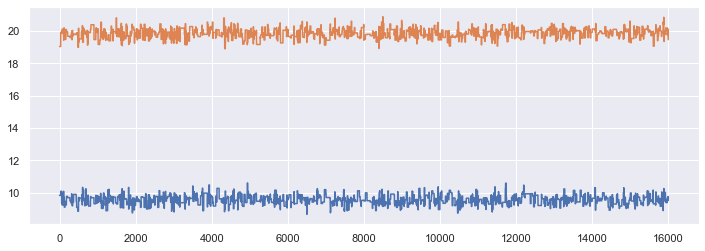

In [29]:
for param in range(samplings.shape[0]):
    plt.plot(samplings[param,:])
plt.savefig('coupling_abc_mult_sampling.png')

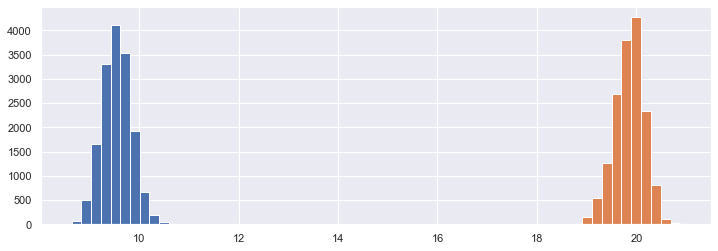

In [30]:
for param in range(samplings.shape[0]):
    plt.hist(samplings[param,:], bins = 10)
plt.savefig('coupling_abc_mult_histogram.png')

#### Sampling for each variable

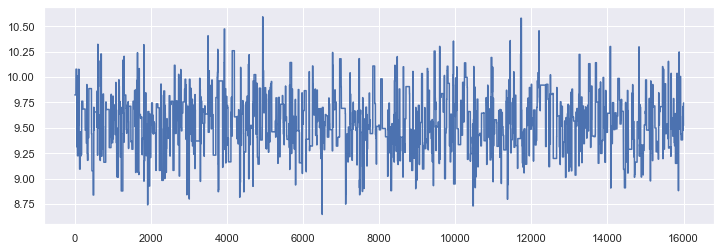

In [31]:
plt.plot(samplings[0,:])
plt.savefig('coupling_abc_mult_sampling_1.png')

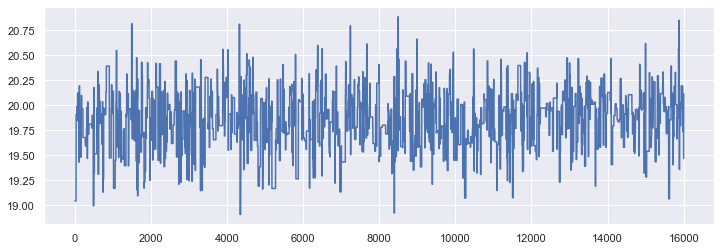

In [32]:
plt.plot(samplings[1,:])
plt.savefig('coupling_abc_mult_sampling_2.png')

#### Meeting time for each variable
Note that a MH is runned to have both chains as an example

In [33]:
(red_chain, blue_chain) = metropolis_hastings(iterations,observations_y, S2, 0.2)

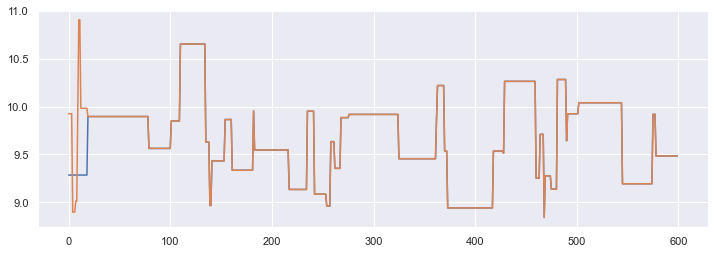

In [34]:
plt.plot(red_chain[0,:])
plt.plot(blue_chain[0,:])
plt.savefig('coupling_abc_mult_chain_meeeting_1.png')

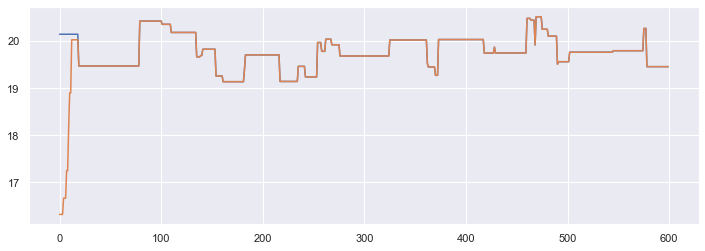

In [35]:
plt.plot(red_chain[1,:])
plt.plot(blue_chain[1,:])
plt.savefig('coupling_abc_mult_chain_meeeting_2.png')

#### Histograms for all variables with real posterior (old, see later)

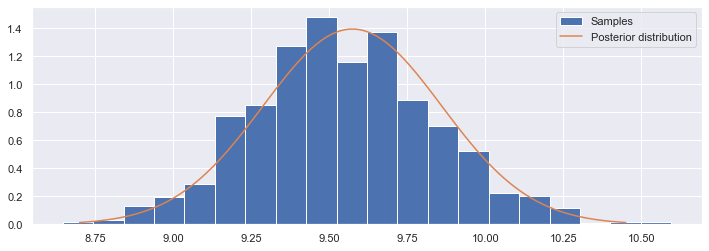

In [62]:
x = np.linspace(8.7, 10.45,100)

plt.hist(samplings[0,:], bins = 20, density=True, label='Samples')
plt.plot(x, sstat.norm.pdf(x, 9.574, 0.286 ) , label= 'Posterior distribution' )

plt.legend()

plt.savefig('coupling_abc_mult_histogram_1.png')

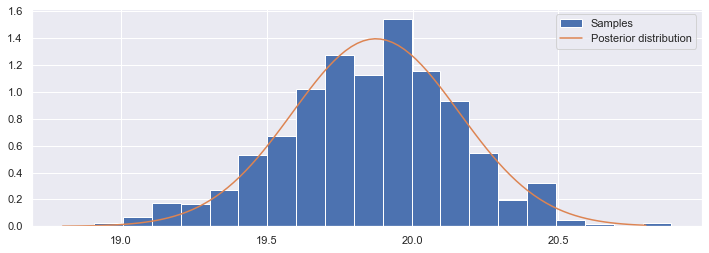

In [63]:
x = np.linspace(18.8, 20.8, 100)

plt.hist(samplings[1,:],bins = 20, density=True, label='Samples')
plt.plot(x, sstat.norm.pdf(x, 19.874, 0.286 ) , label= 'Posterior distribution' )

plt.legend()

plt.savefig('coupling_abc_mult_histogram_2.png')